In [1]:
import tensorflow as tf

# Make sure we run on Tensowflow 2:
print(tf.__version__)

2.4.0


# Read and prepare dataset
First, we start with defining helper functions to plot time series and reading data from csv:

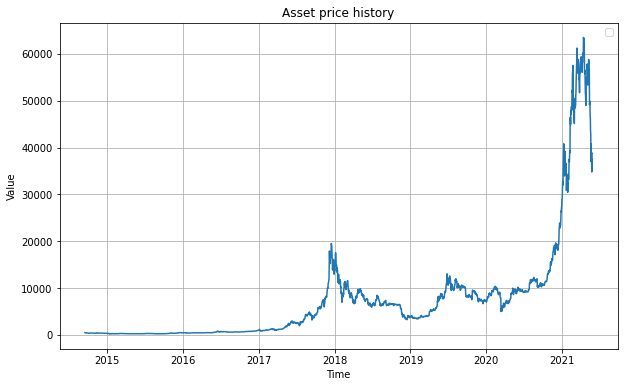

In [5]:
import csv
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None, title="Asset price history", legend=[]):
    plt.plot(time[start:end], series[start:end], format)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(legend)
    plt.grid(True)

def read_data(filepath='sample_data/BTC-USD.csv'):
    DATE_FORMAT = "%Y-%m-%d"
    time_step = []
    prices = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # skip header
        for row in reader:
            if row[4] != 'null':
                time_step.append(datetime.strptime(row[0], DATE_FORMAT).date())
                prices.append(float(row[4]))
    return np.array(time_step), np.array(prices)

time, series = read_data()

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now that we have the time series, let's split it into a training and validation set, so we can start forecasting:


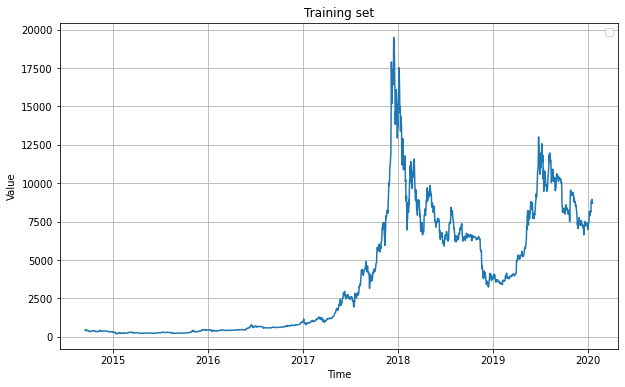

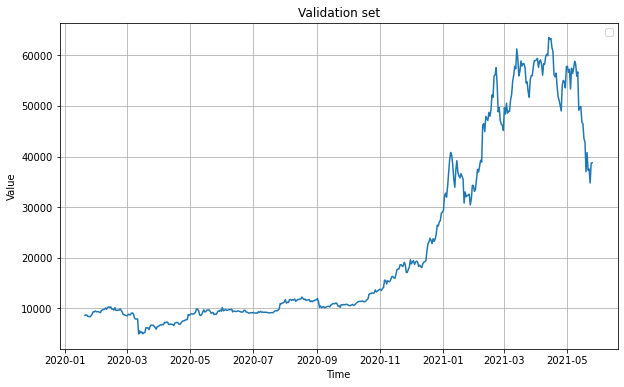

In [18]:
split_time = int(len(time) * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Plot training data:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train, title="Training set")
plt.show()

# Plot validation data
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, title="Validation set")
plt.show()


# Naive Forecast

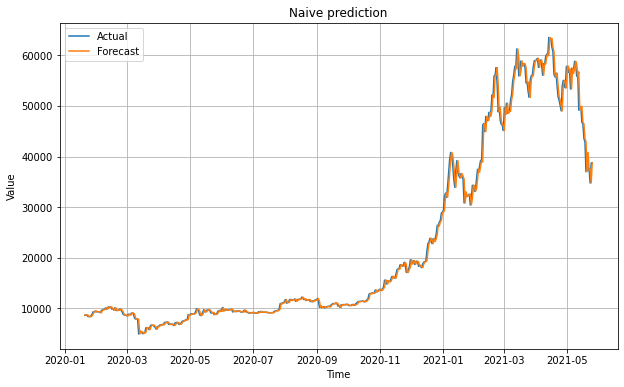

In [19]:
# calculate the forecast based on the previous day
naive_forecast = series[split_time - 1:-1]

# Plot naive forecast vs. Actual data
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast, title="Naive prediction", legend=["Actual", "Forecast"])

Let's zoom in on the start of the validation period:

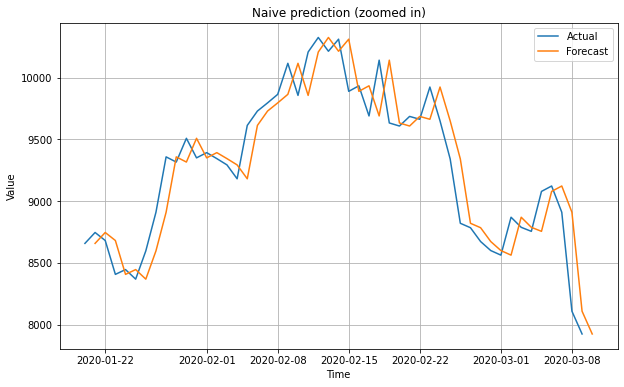

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=50)
plot_series(time_valid, naive_forecast, start=1, end=51, title="Naive prediction (zoomed in)", legend=["Actual", "Forecast"])

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [21]:
print("MSE:")
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print("MAE:")
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

MSE:
1567890.9365762253
MAE:
668.2866531270491


We will use the results of Naive implementation as our baseline to compare against other models.

# Moving Average
Now let's implement Moving Average. First, we define a function that will calculate moving average on a given time series:

In [12]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
       If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)


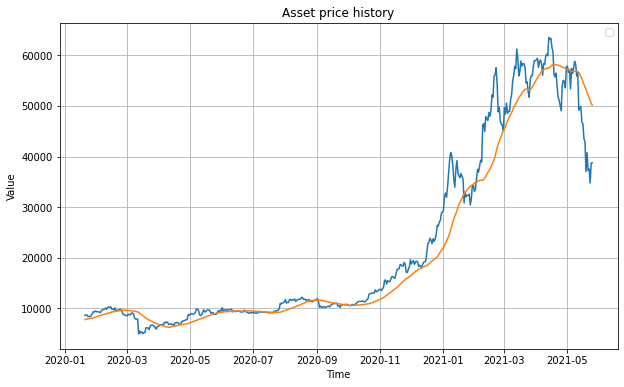

In [13]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

Let's print the performance metrics:

In [14]:
print("MSE:")
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print("MAE:")
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

MSE:
17180985.74535265
MAE:
2472.22143907015
